In [45]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/customer-churn-ml-engineering

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/customer-churn-ml-engineering


In [48]:
import sys
import os

# Adds the current directory to the path so 'import src' works
sys.path.append(os.getcwd())

# If your 'src' folder is inside another folder, add that full path instead:
# sys.path.append('/content/drive/MyDrive/YourProjectFolder')


In [55]:
sys.path.append('/content/customer-churn-ml-engineering/src/data')
import loader  # Instead of from src import data



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


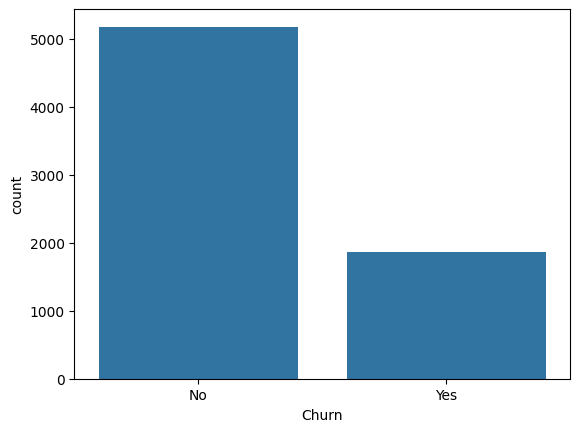

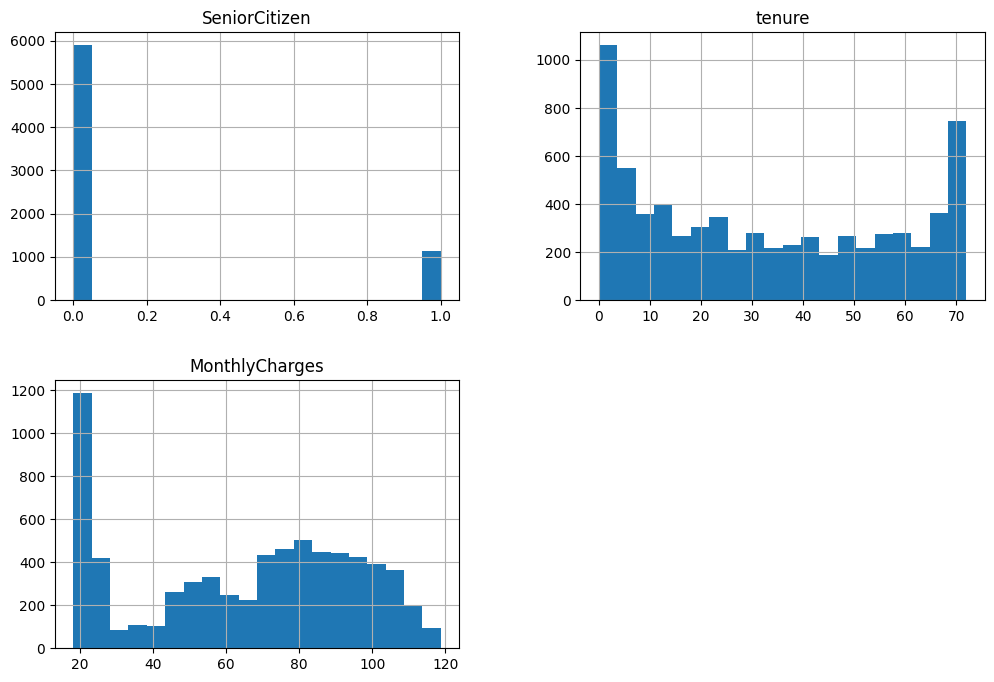

0.6979720478441707
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.62      0.51      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



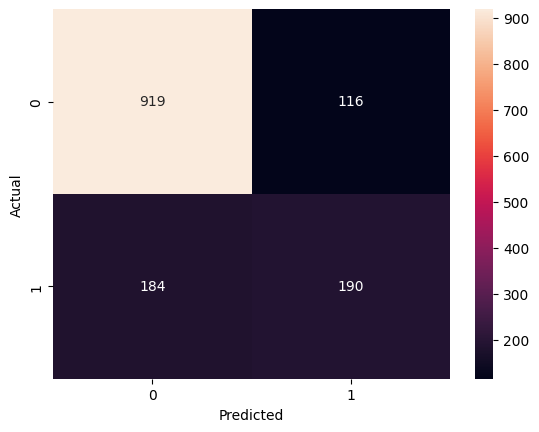

In [67]:

# ===============================
# Phase 1: Exploration & Baseline Modeling
# Project: Customer Churn Prediction
# ===============================

# -------------------------------
# 1. Setup / Imports
# -------------------------------
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import sys
sys.path.append('/content/customer-churn-ml-engineering/src/data')
import loader  # Instead of from src import data
from loader import load_csv

sys.path.append('/content/customer-churn-ml-engineering/src/features')
import preprocess  # Instead of from src import data
from preprocess import prepare_features

sys.path.append('/content/customer-churn-ml-engineering/src/models')
import train  # Instead of from src import data
from train import train_model
import evaluate
from evaluate import evaluate_model

import joblib

sys.path.append('/content/customer-churn-ml-engineering/src/utils')
import paths  # Instead of from src import data
from paths import MODELS_DIR

import warnings
warnings.filterwarnings('ignore')

# -------------------------------
# 2. Mount Google Drive
# -------------------------------


# Update path according to your Drive folder
csv_path = "/content/drive/MyDrive/customer-churn-ml-engineering/WA_Fn-UseC_-Telco-Customer-Churn.csv"

# -------------------------------
# 3. Load Dataset
# -------------------------------

df = load_csv(csv_path)
df.head()

# -------------------------------
# 4. Exploratory Data Analysis (EDA)
# -------------------------------

# Basic info
print(df.info())
print(df.describe())

# Missing values
print(df.isnull().sum())

# Class balance
print(df['Churn'].value_counts(normalize=True))

# Visualizations
sns.countplot(x='Churn', data=df)
plt.show()

# Example: Histogram of numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
df[numeric_cols].hist(bins=20, figsize=(12, 8))
plt.show()

# -------------------------------
# 5. Preprocessing / Feature Engineering
# -------------------------------

X, y, artifacts = prepare_features(df)

joblib.dump(artifacts, MODELS_DIR / "preprocess_artifacts.joblib")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# -------------------------------
# 6. Baseline Models
# -------------------------------
# XGBoost
#Training Module #Evaluation Module

model = train_model(X_train, y_train, MODELS_DIR)

metrics = evaluate_model(model, X_test, y_test)
print(metrics["roc_auc"])
print(metrics["report"])



y_pred_xgb = model.predict(X_test)




# Confusion matrix example
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# -------------------------------
# 7. Notes & Next Steps
# -------------------------------
# - Check feature importance
# - Handle class imbalance if needed
# - Prepare pipeline for Phase 2 (production-ready code)
